In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

from qiskit import BasicAer
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components import variational_forms
from qiskit.aqua.components.optimizers import COBYLA

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

from data_provider import load_titanic_pd
from utils import record_test_result_for_kaggle

In [2]:
df_train, y_train, df_test = load_titanic_pd('train.csv', 'test.csv')

/Users/barnrang/Desktop/work/github/qc_group_project/data_provider.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col][i] = numer_map[df[col][i]]
/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/Users/barnrang/Desktop/work/github/qc_group_project/data_provider.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col][i] = value


     Survived  Pclass Sex Age  SibSp  Parch      Fare Embarked
0           0       3   0  22      1      0    7.2500        0
1           1       1   1  38      1      0   71.2833        1
2           1       3   1  26      0      0    7.9250        0
3           1       1   1  35      1      0   53.1000        0
4           0       3   0  35      0      0    8.0500        0
5           0       3   0  30      0      0    8.4583        2
6           0       1   0  54      0      0   51.8625        0
7           0       3   0   2      3      1   21.0750        0
8           1       3   1  27      0      2   11.1333        0
9           1       2   1  14      1      0   30.0708        1
10          1       3   1   4      1      1   16.7000        0
11          1       1   1  58      0      0   26.5500        0
12          0       3   0  20      0      0    8.0500        0
13          0       3   0  39      1      5   31.2750        0
14          0       3   1  14      0      0    7.8542  

/Users/barnrang/Desktop/work/github/qc_group_project/data_provider.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col][i] = value


In [5]:
for col in df_train.columns:
    print(f"{col}: unique {len(df_train[col].unique())}")

Pclass: unique 3
Sex: unique 2
Age: unique 88
SibSp: unique 7
Parch: unique 7
Fare: unique 248
Embarked: unique 4


In [6]:
# Age processing

df_train['Age'] = df_train.Age // 10
df_test['Age'] = df_test.Age // 10

In [7]:
def fare_map(x):
    if x < 10:
        return 0
    if x < 20:
        return 1
    if x < 30:
        return 2
    else:
        return 3
    
df_train['Fare'] = df_train['Fare'].apply(fare_map)
df_test['Fare'] = df_test['Fare'].apply(fare_map)

In [8]:
df_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,2,1,0,0,0
1,1,1,3,1,0,3,1
2,3,1,2,0,0,0,0
3,1,1,3,1,0,3,0
4,3,0,3,0,0,0,0


In [13]:
from sklearn import preprocessing

df_all = pd.concat([df_train, df_test])
# Encode to number
for col in df_train.columns:
    le = preprocessing.LabelEncoder().fit(df_all[col])
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

In [14]:
# b1b2b3 --> (theta, varphi)
def convert_to_angle(b_st):
    if b_st[0] == '1':
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[1] == '1' and b_st[2] == '1':
        varphi = np.pi / 4

    if b_st[1] == '1' and b_st[2] == '0':
        varphi = 3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '0':
        varphi = -3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '1':
        varphi = -np.pi / 4
            
    return [theta, varphi]

data_train = []
data_test = []

bit_each_col = []

# Check number of different category in df_all
for col in df_all.columns:
    bit_each_col.append(int(np.ceil(np.log2(len(df_all[col].unique())))))
    
# Count required bit
num_bit = sum(bit_each_col)
num_qubit = int(np.ceil(num_bit / 3))

pad = 0
if num_bit % 3 != 0:
    pad = 3 - (num_bit % 3)

    
# Encode train
for row in df_train.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_train.append(var_list)
    
# Encode Test
for row in df_test.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_test.append(var_list)

# data = np.concatenate(data, axis=1)
data_train = np.array(data_train)
data_test = np.array(data_test)

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


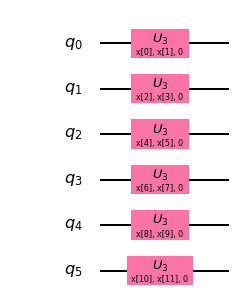

In [15]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data_train.shape[1])]

var_form = variational_forms.RYRZ(num_qubit)

qc = QuantumCircuit(num_qubit)

for i in range(num_qubit):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder

feature_map = qc 
feature_map.draw('mpl')

In [17]:
# Make training data

training_input = {
    0: data_train[y_train == 0],
    1: data_train[y_train == 1]
}

In [25]:
# 

seed = 10598

vqc_encode_only_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_only_log.append(loss)

qsvm_encode = VQC(COBYLA(100), feature_map, var_form, training_input, callback=loss_history_callback)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  if __name__ == '__main__':
2020-07-09 00:30:00,440:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-07-09 00:30:00,454:qiskit.aqua.algorithms.v

KeyboardInterrupt: 

In [ ]:
def record_test_result_for_kaggle(y_pred, submission_file):
    start = 892
    end = 1309
    result = "PassengerId,Survived\n"
    for i in range(start, end + 1):
        result += "%d,%d\n" % (i, y_pred[i - 892])
    with open(submission_file, "w", encoding="utf-8") as writer:
        writer.write(result)

prediction = qsvm_encode.predict(data_test)[1]
record_test_result_for_kaggle(prediction, 'submission.csv')

In [36]:
prediction = np.zeros(len(df_test))
record_test_result_for_kaggle(prediction, 'stupid_submission.csv')

In [ ]:
qsvm_encode.save_model('models/Titanic_VQC')

In [26]:
# load model 
# qsvm_encode = VQC(COBYLA(1), feature_map, var_form, training_input)
# backend = BasicAer.get_backend('qasm_simulator')
# quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
# qsvm_encode.run(quantum_instance)

qsvm_encode.load_model('models/Titanic_VQC.npz')

In [28]:
prediction = qsvm_encode.predict(data_train)[1]

np.mean(prediction == y_train), f1_score(prediction, y_train)

2020-07-09 00:33:37,543:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


NameError: name 'f1' is not defined

In [33]:
np.mean(prediction == y_train), f1_score(prediction, y_train)

(0.675645342312009, 0.5743740795287187)

# Continuoue+mix encoding (VQC + QRAC)

In [ ]:
df_train, y_train, df_test = load_titanic_pd('train.csv', 'test.csv')

In [12]:
df_train['Fare'] = np.log(df_train['Fare'] + 1)
df_test['Fare'] = np.log(df_test['Fare'].astype(np.float32) + 1)

TypeError: loop of ufunc does not support argument 0 of type float which has no callable log method

In [ ]:
df_test

In [16]:
df_test['Fare']

array([2.17806435, 2.07944155, 2.36907482, 2.26825237, 2.5868237 ,
       2.32483578, 2.15515184, 3.40119743, 2.1076889 , 3.22485781,
       2.1855793 , 3.29583693, 4.42204857, 4.12995291, 3.35762167,
       2.59151649, 2.10717845, 2.18885636, 4.10098934, 1.42810786,
       3.48686433, 4.13323212, 5.57357883, 2.74083996, 4.14280462,
       3.44998765, 3.12144828, 3.48124003, 3.07153535, 3.19663024,
       4.0732913 , 2.20276475, 2.35137534, 4.05171204, 2.66838717,
       3.31600261, 2.18041754, 2.6390574 , 3.98069429, 3.42426276,
       2.16905379, 4.34758663, 2.82731366, 4.1108737 , 2.77466774,
       3.17805386, 5.57594919, 2.80814886, 3.40535545, 2.15755939,
       2.83907843, 2.67414856, 2.16619253, 3.09104252, 2.18371153,
       3.77045941, 3.38566065, 5.35894203, 3.28466368, 2.78783441,
       5.40618134, 2.46029806, 2.73788071, 2.70136118, 2.17190671,
       3.97029185, 2.17427444, 4.38014984, 2.18089199, 4.03320837,
       2.25304818, 3.15806365, 2.17711258, 2.27341366, 2.77544

In [17]:
df_train['Age'] = df_train['Age'] / 60
df_test['Age'] = df_test['Age'] / 60

In [20]:
cat_col = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
num_col = ['Age', 'Fare']

In [21]:
df_train_cat = df_train[cat_col]
df_test_cat = df_test[cat_col]

df_train_num = df_train[num_col]
df_test_num = df_test[num_col]

In [22]:
# b1b2b3 --> (theta, varphi)
def convert_to_angle(b_st):
    if b_st[0] == '1':
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[1] == '1' and b_st[2] == '1':
        varphi = np.pi / 4

    if b_st[1] == '1' and b_st[2] == '0':
        varphi = 3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '0':
        varphi = -3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '1':
        varphi = -np.pi / 4
            
    return [theta, varphi]

data_train = []
data_test = []

bit_each_col = []

df_all = pd.concat([df_train_cat, df_test_cat])

# Check number of different category in df_all
for col in df_all.columns:
    bit_each_col.append(int(np.ceil(np.log2(len(df_all[col].unique())))))
    
# Count required bit
num_bit = sum(bit_each_col)
num_qubit = int(np.ceil(num_bit / 3))

pad = 0
if num_bit % 3 != 0:
    pad = 3 - (num_bit % 3)

    
# Encode train
for row in df_train_cat.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_train.append(var_list)
    
# Encode Test
for row in df_test_cat.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_test.append(var_list)

# data = np.concatenate(data, axis=1)
data_train = np.array(data_train)
data_test = np.array(data_test)

In [45]:
data_train_num = df_train_num.values
data_test_num = df_test_num.values

In [46]:
data_train = np.concatenate([data_train, data_train_num], axis=1)
data_test = np.concatenate([data_test, data_test_num], axis=1)

In [48]:
data_train.shape, data_test.shape

((891, 10), (418, 10))

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  if sys.path[0] == '':


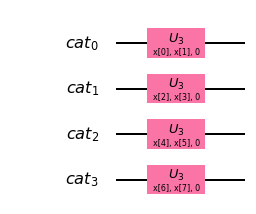

In [38]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter, QuantumRegister
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data_train.shape[1])]

qr = QuantumRegister(num_qubit, 'cat')
qc = QuantumCircuit(qr)

for i in range(num_qubit):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder
# tmp1 = feature_map.assign_parameters(X[:num_qubit])
# tmp2 = feature_map.assign_parameters(X[num_qubit:])

feature_map_cat = qc #+ tmp1 + tmp2 
feature_map_cat.draw('mpl')

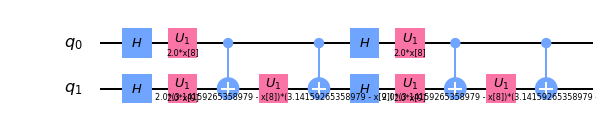

In [39]:
# Continuous circuit

X1 = Parameter('x[8]')
X2 = Parameter('x[9]')

feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement='linear')

feature_map = feature_map.assign_parameters([X1, X2])

feature_map.draw('mpl')

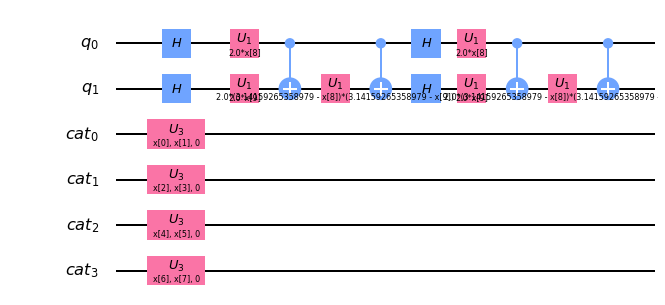

In [51]:
feature_map_all = feature_map.combine(feature_map_cat)
feature_map_all.draw('mpl')

In [54]:
# Make training data

training_input = {
    0: data_train[y_train == 0],
    1: data_train[y_train == 1]
}

In [56]:
data_train.shape

(891, 10)

In [58]:
num_qubit

4

In [60]:
# 

seed = 10598

vqc_encode_with_num_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_with_num_log.append(loss)


# feature_map = ZZFeatureMap(feature_dimension=num_qubit, reps=2, entanglement='linear')
var_form = variational_forms.RYRZ(6, depth=4)

qsvm_encode = VQC(COBYLA(100), feature_map_all, var_form, training_input, callback=loss_history_callback)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  del sys.path[0]
2020-07-09 14:41:55,887:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra

2020-07-09 15:03:45,854:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6453861793401688
2020-07-09 15:04:42,301:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6409202333494594
2020-07-09 15:05:27,583:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6245638952389377
2020-07-09 15:06:09,103:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6277012094260065
2020-07-09 15:06:52,542:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6086483250338013
2020-07-09 15:07:34,018:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6228379968756191
2020-07-09 15:08:18,484:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.619451927809176
2020-07-09 15:09:04,164:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6217663370943118
2020-07-09 15:09:47,532:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch 

In [61]:
def record_test_result_for_kaggle(y_pred, submission_file):
    start = 892
    end = 1309
    result = "PassengerId,Survived\n"
    for i in range(start, end + 1):
        result += "%d,%d\n" % (i, y_pred[i - 892])
    with open(submission_file, "w", encoding="utf-8") as writer:
        writer.write(result)

prediction = qsvm_encode.predict(data_test)[1]
record_test_result_for_kaggle(prediction, 'encode_with_num_submission.csv')

2020-07-09 16:00:16,890:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


In [62]:
# load model 
# qsvm_encode = VQC(COBYLA(1), feature_map, var_form, training_input)
# backend = BasicAer.get_backend('qasm_simulator')
# quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
# qsvm_encode.run(quantum_instance)

qsvm_encode.save_model('models/Titanic_VQC_withnum.npz')

In [63]:
prediction = qsvm_encode.predict(data_train)[1]

np.mean(prediction == y_train), f1_score(prediction, y_train)

2020-07-09 16:17:43,257:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.7250280583613917, 0.5896147403685091)

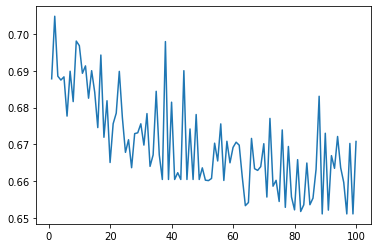

In [39]:
x_plot = np.arange(1,101)
plt.plot(x_plot, vqc_encode_ZZ_log)

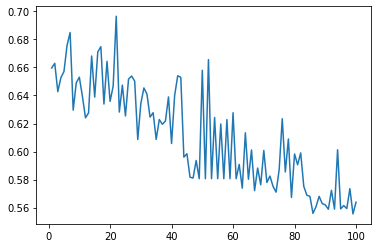

In [64]:
x_plot = np.arange(1,101)
plt.plot(x_plot, vqc_encode_with_num_log_with_num_log)